# 📊 Анализ данных и прогнозирование цен на арматуру
В этом ноутбуке мы проведем анализ данных, подготовим признаки и обучим модели для предсказания цен на арматуру.

**Методы:**
- 📈 Анализ и визуализация данных
- 🔄 Проверка стационарности ряда
- 🏗 Создание новых признаков
- 🤖 Обучение моделей (LightGBM и LSTM)
- 📊 Оценка качества предсказаний

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
train_df = pd.read_excel("data/train.xlsx")
test_df = pd.read_excel("data/test.xlsx")
fuel_df = pd.read_excel("data/Топливо.xlsx")
metal_df = pd.read_excel("data/Показатели рынка металла.xlsx")

# Преобразуем даты
train_df["dt"] = pd.to_datetime(train_df["dt"], errors="coerce")
test_df["dt"] = pd.to_datetime(test_df["dt"], errors="coerce")

# Вывод первых строк
train_df.head()


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


## 📊 Первичный анализ данных

In [38]:

# Проверка структуры данных
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("Fuel dataset shape:", fuel_df.shape)
print("Metal dataset shape:", metal_df.shape)

# Проверяем пропущенные значения
print("Пропущенные значения в train:")
print(train_df.isnull().sum())

# Статистическое описание данных
train_df.describe()


Train dataset shape: (400, 2)
Test dataset shape: (28, 2)
Fuel dataset shape: (76, 3)
Metal dataset shape: (85, 81)
Пропущенные значения в train:
dt                  0
Цена на арматуру    0
dtype: int64


,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


## 📈 Динамика цен на арматуру

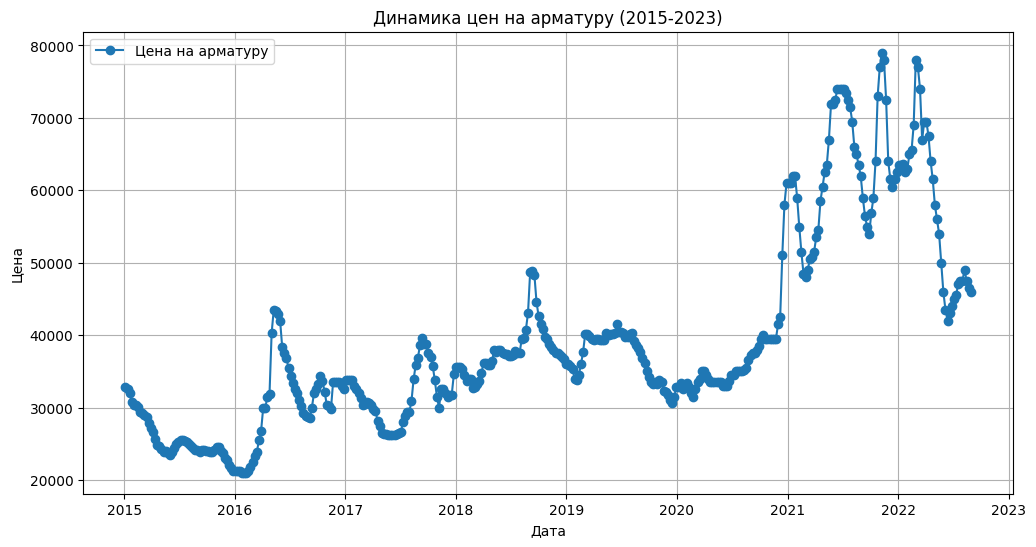

In [39]:

plt.figure(figsize=(12, 6))
plt.plot(train_df["dt"], train_df["Цена на арматуру"], label="Цена на арматуру", marker="o")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Динамика цен на арматуру (2015-2023)")
plt.legend()
plt.grid()
plt.show()


## 🔍 Корреляция цен с макропоказателями

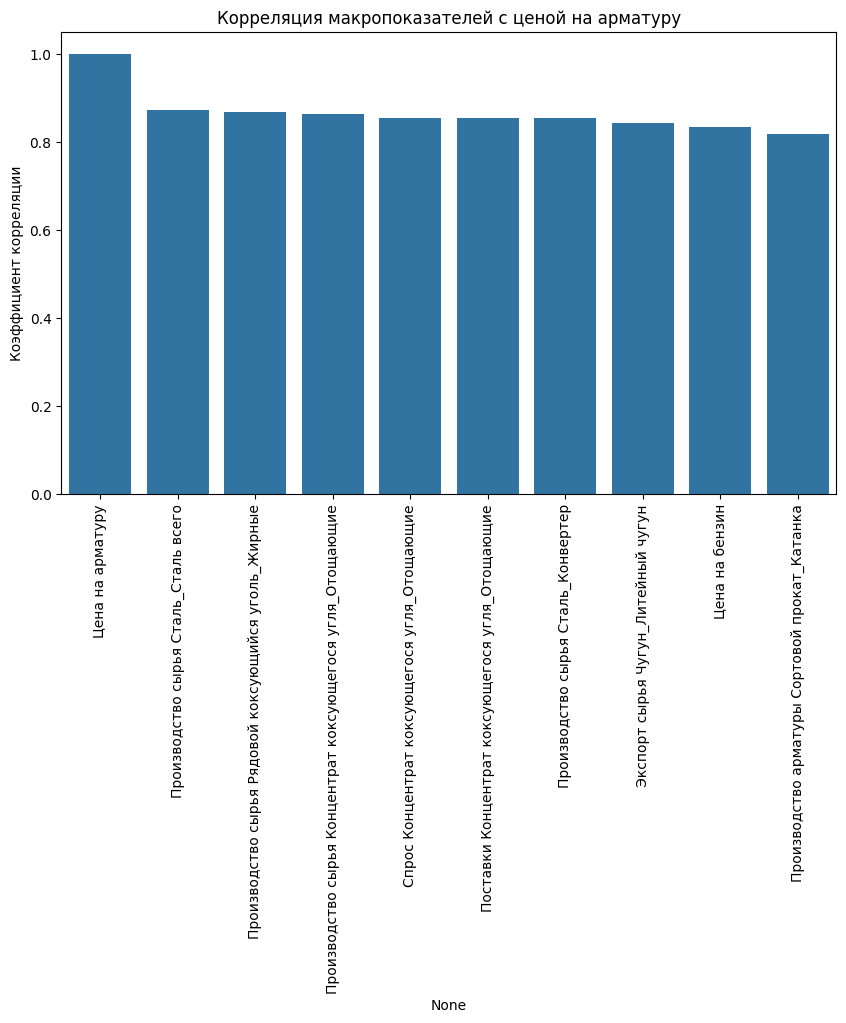

In [40]:

merged_df = train_df.merge(fuel_df, on="dt", how="left").merge(metal_df, on="dt", how="left")
numeric_df = merged_df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()["Цена на арматуру"].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation[:10].index, y=correlation[:10].values)
plt.xticks(rotation=90)
plt.ylabel("Коэффициент корреляции")
plt.title("Корреляция макропоказателей с ценой на арматуру")
plt.show()


## 🔬 Проверка стационарности временного ряда

In [41]:

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    print("📌 ADF Statistic:", result[0])
    print("📌 p-value:", result[1])
    if result[1] < 0.05:
        print("✅ Ряд стационарен (p < 0.05)")
    else:
        print("⚠️ Ряд нестационарен (p >= 0.05)")

check_stationarity(train_df["Цена на арматуру"])


📌 ADF Statistic: -1.9258699893713447
📌 p-value: 0.3199906102569918
⚠️ Ряд нестационарен (p >= 0.05)


## 🔄 Преобразование данных для обучения моделей

📌 ADF Statistic: -7.706061504115208
📌 p-value: 1.3006938373809844e-11
✅ Ряд стационарен (p < 0.05)


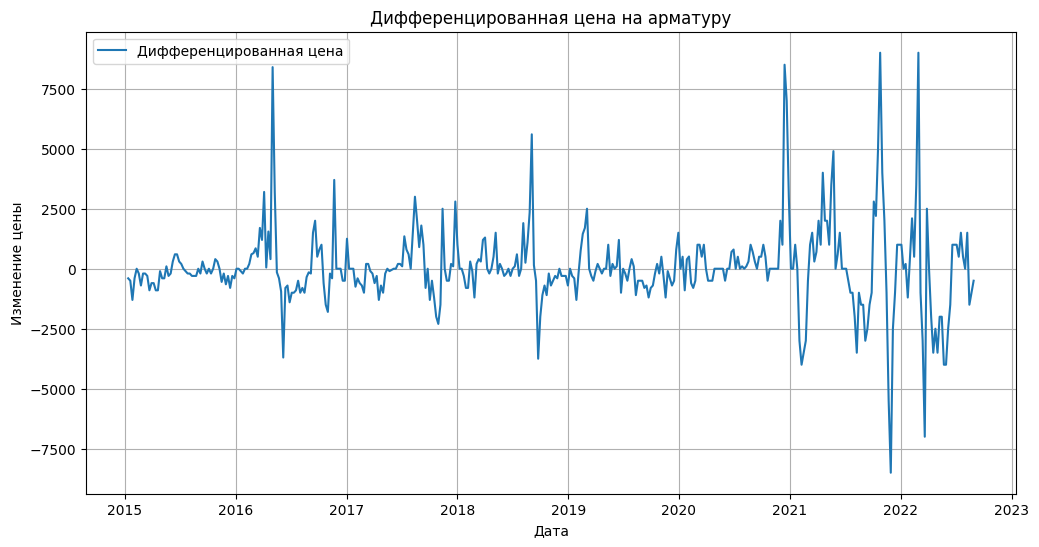

In [42]:

# Применяем разностное преобразование
train_df["diff_price"] = train_df["Цена на арматуру"].diff()
check_stationarity(train_df["diff_price"])

# Визуализируем
plt.figure(figsize=(12, 6))
plt.plot(train_df["dt"], train_df["diff_price"], label="Дифференцированная цена")
plt.xlabel("Дата")
plt.ylabel("Изменение цены")
plt.title("Дифференцированная цена на арматуру")
plt.legend()
plt.grid()
plt.show()


## 🏗 Создание новых признаков

In [43]:

lags = [1, 4, 6, 8, 12]
for lag in lags:
    train_df[f"lag_{lag}"] = train_df["Цена на арматуру"].shift(lag)

windows = [4, 8, 12]
for window in windows:
    train_df[f"rolling_mean_{window}"] = train_df["Цена на арматуру"].rolling(window).mean()

train_df.dropna(inplace=True)
train_df.head()


,dt,Цена на арматуру,diff_price,lag_1,lag_4,lag_6,lag_8,lag_12,rolling_mean_4,rolling_mean_8,rolling_mean_12
12,2015-03-30,27200,-600.0,27800.0,29200.0,30100.0,30300.0,32900.0,28175.0,28962.5,29766.666667
13,2015-04-06,26600,-600.0,27200.0,29000.0,29400.0,30300.0,32500.0,27575.0,28500.0,29275.000000
14,2015-04-13,25700,-900.0,26600.0,28700.0,29200.0,30100.0,32000.0,26825.0,27950.0,28750.000000
15,2015-04-20,24800,-900.0,25700.0,27800.0,29000.0,29400.0,30700.0,26075.0,27375.0,28258.333333
16,2015-04-27,24700,-100.0,24800.0,27200.0,28700.0,29200.0,30300.0,25450.0,26812.5,27791.666667


## 🤖 Обучение модели LightGBM

In [44]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

features = [col for col in train_df.columns if col not in ["dt", "Цена на арматуру"]]
target = "Цена на арматуру"

X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": 5,
    "verbose": -1
}

model_lgbm = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=500, callbacks=[lgb.early_stopping(50)])

y_pred_lgbm = model_lgbm.predict(X_val)

rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm))
mape_lgbm = mean_absolute_percentage_error(y_val, y_pred_lgbm) * 100

print(f"📉 LightGBM RMSE: {rmse_lgbm:.2f} руб.")
print(f"📊 LightGBM MAPE: {mape_lgbm:.2f}%")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's rmse: 1338.53
📉 LightGBM RMSE: 1338.53 руб.
📊 LightGBM MAPE: 1.80%
